# Table of Contents

* [SVD vs Positive-only SVD](#SVD-vs-Positive-only-SVD)
	* [Items distribution in training datasets](#Items-distribution-in-training-datasets)
* [Recommended movies distribution](#Recommended-movies-distribution)
* [Dependence on holdout size](#Dependence-on-holdout-size)
	* [Top-rated evaluation](#Top-rated-evaluation)
	* [Mixed ratings evaluation](#Mixed-ratings-evaluation)
* [Dependence on top-k](#Dependence-on-top-k)
	* [Amount of positive and negative ratings per user in the test set](#Amount-of-positive-and-negative-ratings-per-user-in-the-test-set)
	* [Almost standard scenario (full test data)](#Almost-standard-scenario-%28full-test-data%29)
	* [Cold-start](#Cold-start)
		* [Negative feedback count](#Negative-feedback-count)
		* [From 1 negative](#From-1-negative)
			* [Standard models predict highest scores ("direct" predictions scenario)](#Standard-models-predict-highest-scores-%28"direct"-predictions-scenario%29)
			* [Standard models predict lowest scores ("reversed" prediction)](#Standard-models-predict-lowest-scores-%28"reversed"-prediction%29)
		* [From 3 negative](#From-3-negative)
			* [Direct](#Direct)
			* [Reversed](#Reversed)
		* [From 1 random](#From-1-random)
		* [From 3 random](#From-3-random)
	* [From 5 random](#From-5-random)
* [Orthogonalization effect on MF methods](#Orthogonalization-effect-on-MF-methods)

In [1]:
import sys
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import basename

import seaborn as sns
sns.set_style('white')

from polara.recommender.data import RecommenderData, RecommenderDataPositive
from polara.recommender.models import SVDModel, CoffeeModel, NonPersonalized
from polara.evaluation import evaluation_engine as ee
from polara.evaluation.plotting import show_hits, show_hit_rates, show_precision_recall, show_ranking, show_relevance, show_ranking_positivity
from polara.tools.mymedialite.mmlwrapper import MyMediaLiteWrapper
from polara.tools.movielens import get_movielens_data, filter_short_head
from polara.tools.printing import print_frames

In [2]:
ml_file = "ml-1m.zip"
if sys.platform == 'win32':
    lib_path = 'MyMediaLite-3.11/lib/mymedialite' 
else:
    lib_path = 'MyMediaLite-3.11/bin'
data_folder = 'MyMediaLiteData'

def get_file_name(filepath):
    return ''.join(basename(filepath).split('.')[:-1])

In [3]:
ml_data, ml_genres = get_movielens_data(local_file=ml_file, get_genres=True)
movielens = RecommenderData(ml_data, 'userid', 'movieid', 'rating')
movielens.name = get_file_name(ml_file)

In [4]:
bpr = MyMediaLiteWrapper(lib_path, data_folder, 'BPRMF', movielens)
wrmf = MyMediaLiteWrapper(lib_path, data_folder, 'WRMF', movielens)
wrmf.name='WRMF'
svd = SVDModel(movielens)
popular =  NonPersonalized('mostpopular', movielens)
random = NonPersonalized('random', movielens)
coffee = CoffeeModel(movielens)

In [5]:
models = [bpr, wrmf, svd, coffee, popular, random]
model_names = [model.method for model in models]
metrics = ['hits', 'ranking', 'relevance']
model_names

['BPRMF', 'WRMF', 'SVD', 'CoFFee', 'mostpopular', 'random']

In [6]:
topk_list = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100]
test_samples = [-3, -1, 1, 3, 5, 10, None] #None for all except holdout

In [7]:
holdout_sizes = [1, 2, 3, 5, 7, 10, 15, 19]#np.arange(1, 20) #more than 19 is not possible - not enough highly-rated items

# SVD vs Positive-only SVD

In [8]:
movielenspos = RecommenderDataPositive(4, ml_data, 'userid', 'movieid', 'rating')
movielenspos.name = get_file_name(ml_file)

In [9]:
svdpos = SVDModel(movielenspos)
svdpos.method = 'posSVD'

In [10]:
print svd.topk, svdpos.topk

10 10


In [11]:
movielenspos.training.rating.value_counts()

Preparing data


4    280848
5    180374
Name: rating, dtype: int64

In [12]:
movielens.random_holdout = movielenspos.random_holdout = True
pos_scores_rnd = ee.holdout_test_pair(svd, svdpos, [1, 3, 5, 10, 15], metrics)

movielens.random_holdout = movielenspos.random_holdout = False
pos_scores_top = ee.holdout_test_pair(svd, svdpos, [1, 3, 5, 10, 15], metrics)

1 Preparing data
SVD model is not ready. Rebuilding.
SVD model training time: 0.0674496904676s
Updating test data.
posSVD model is not ready. Rebuilding.
posSVD model training time: 0.0344584938403s
3 Updating test data.
Updating test data.
5 Updating test data.
Updating test data.
10 Updating test data.
Updating test data.
15 Updating test data.
Updating test data.
Data has been changed. Rebuiding the models.
SVD model training time: 0.065268450934s
posSVD model training time: 0.0386448479763s
1 Updating test data.
Updating test data.
3 Updating test data.
Updating test data.
5 Updating test data.
Updating test data.
10 Updating test data.
Updating test data.
15 Updating test data.
Updating test data.


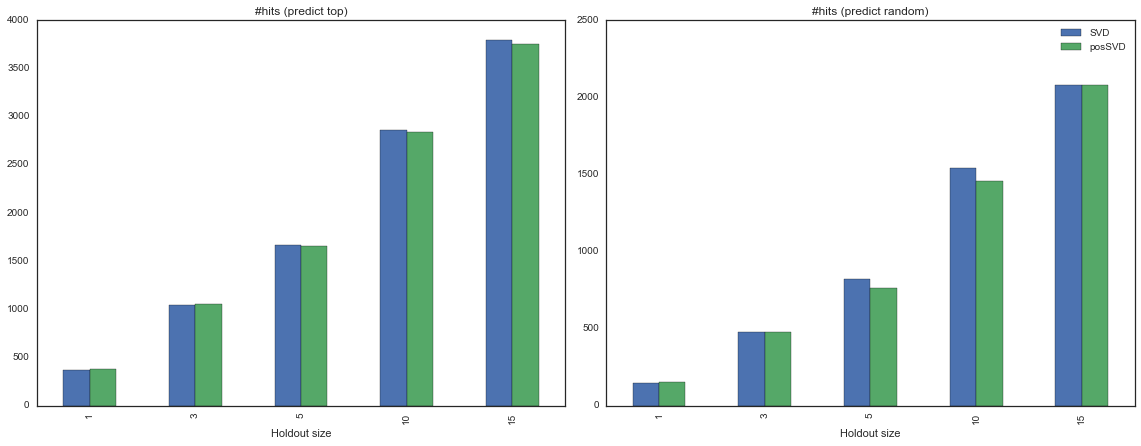

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.tight_layout()
pos_scores_top['hits']['true_positive'].plot.bar(ax=ax[0], title='#hits (predict top)', legend=False)
pos_scores_rnd['hits']['true_positive'].plot.bar(ax=ax[1], title='#hits (predict random)')

for axi in ax:
    axi.set_xlabel('Holdout size')

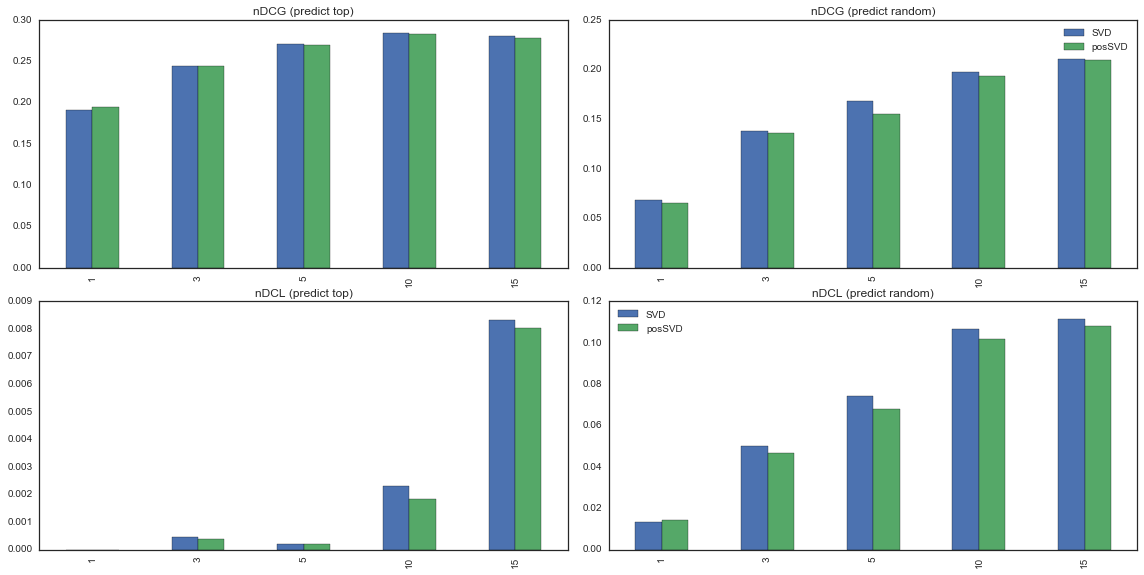

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
fig.tight_layout()
pos_scores_top['ranking']['nDCG'].plot.bar(ax=ax[0, 0], title='nDCG (predict top)', legend=False)
pos_scores_rnd['ranking']['nDCG'].plot.bar(ax=ax[0, 1], title='nDCG (predict random)')
pos_scores_top['ranking']['nDCL'].plot.bar(ax=ax[1, 0], title='nDCL (predict top)', legend=False)
pos_scores_rnd['ranking']['nDCL'].plot.bar(ax=ax[1, 1], title='nDCL (predict random)')

# for axi in ax:
#     axi.set_xlabel('Holdout size')

## Items distribution in training datasets

In [15]:
movielens.get_configuration()

{'holdout_size': 15,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': False,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None}

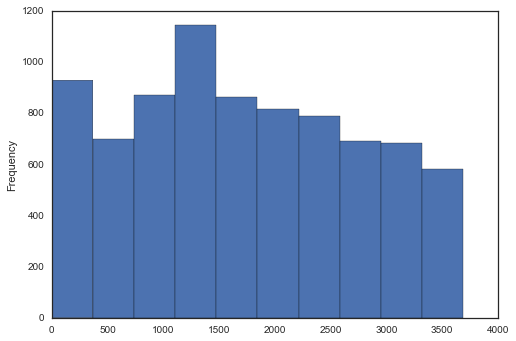

In [16]:
movielens.training.movieid.sample(frac=0.01).plot.hist()

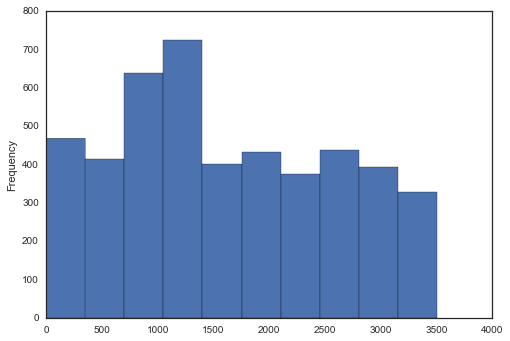

In [17]:
movielenspos.training.movieid.sample(frac=0.01).plot.hist()

Datasets have similar distribution, therefore, better SVDpos performance in terms of nDCL is not just due to lower number of items, but is an effect of better model. Low-rated items create noise for standard SVD.

Iimportant note:  in **ML-10M** dataset all items in the initial dataset are sorted by their popularity. which means that randomization of top-rated items in test is required in order to prevent unwanted biases.

# Recommended movies distribution

Does our recommender tend to follow popularity bias?
In other words - is it similar to global ratings distribution?

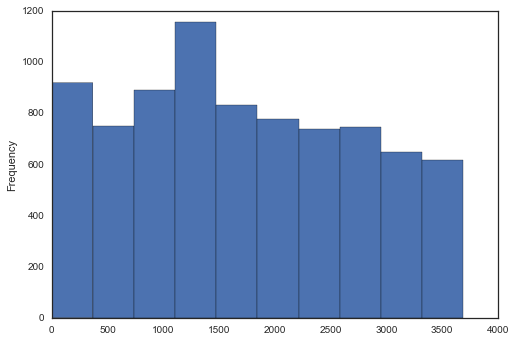

In [18]:
movielens.training.movieid.sample(frac=0.01).plot.hist()

CoFFee model is not ready. Rebuilding.
CoFFee model training time: 1.69293911456s


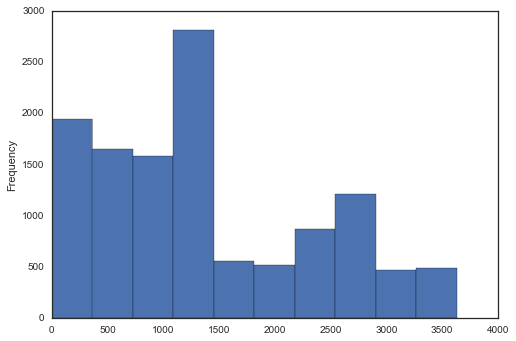

In [19]:
pd.Series(coffee.recommendations.ravel()).plot.hist()

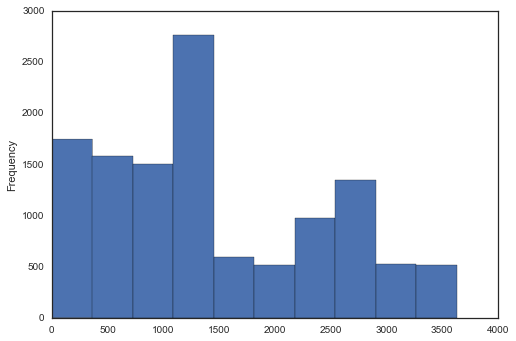

In [20]:
pd.Series(svd.recommendations.ravel()).plot.hist()

BPRMF model is not ready. Rebuilding.


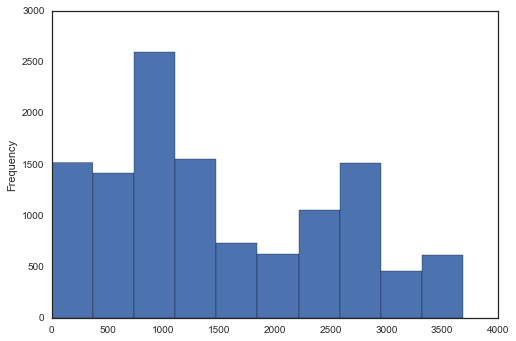

In [21]:
pd.Series(bpr.recommendations.ravel()).plot.hist()

WRMF model is not ready. Rebuilding.


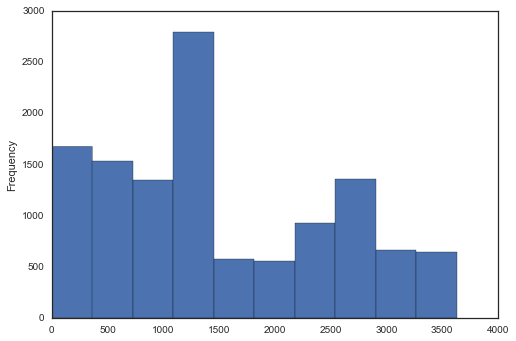

In [22]:
pd.Series(wrmf.recommendations.ravel()).plot.hist()

# Dependence on holdout size

In [23]:
movielens.get_configuration()

{'holdout_size': 15,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': False,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None}

## Top-rated evaluation

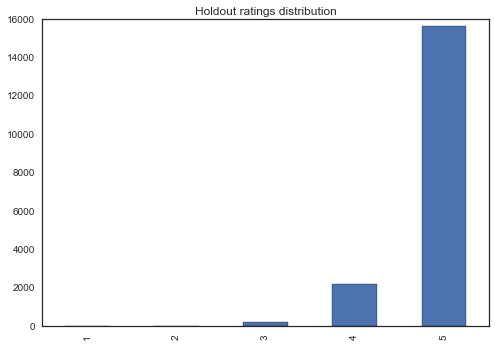

In [24]:
movielens.test.evalset.rating.value_counts().sort_index().plot.bar(title='Holdout ratings distribution')

In [25]:
start_time = timer()
scores = ee.holdout_test(models, holdout_sizes, metrics)
time_delta = timer() - start_time
time_delta

1 Updating test data.
2 Updating test data.
3 Updating test data.
5 Updating test data.
7 Updating test data.
10 Updating test data.
15 Updating test data.
19 Updating test data.


24.164448956819015

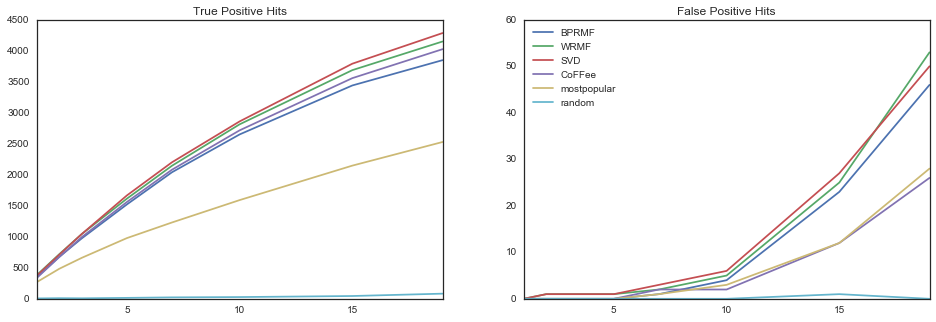

In [26]:
show_hits(scores)
plt.legend(loc='best')

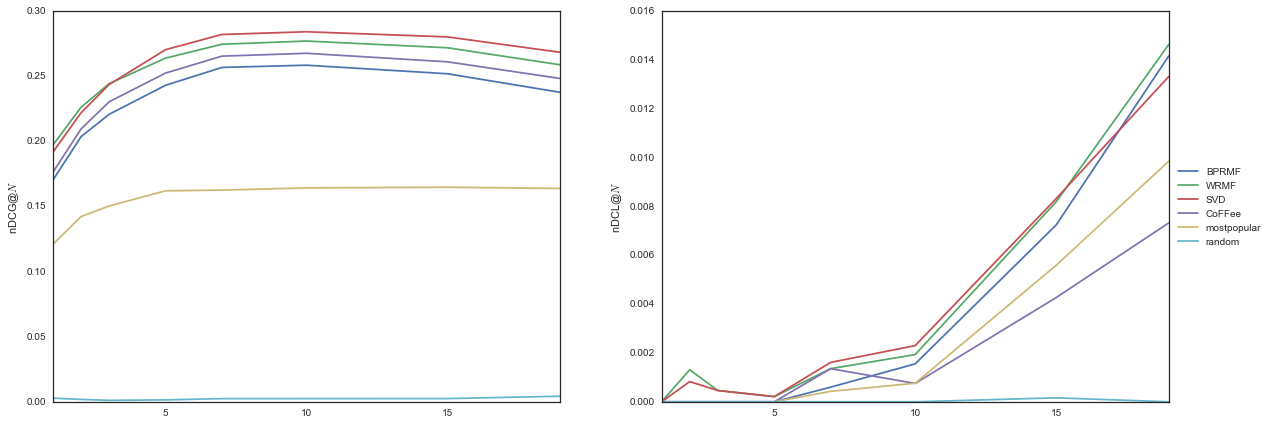

In [27]:
show_ranking(scores, limit=False, figsize=(20, 7))

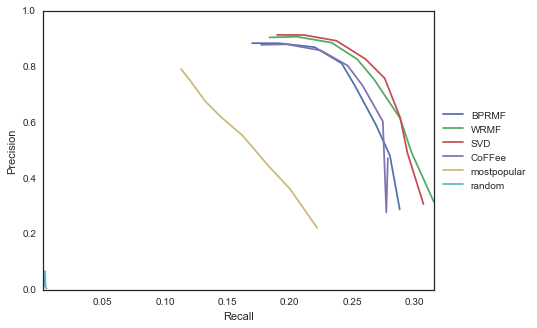

In [28]:
show_precision_recall(scores, figsize=(7, 5))

## Mixed ratings evaluation

In [29]:
movielens.random_holdout = True
movielens.permute_tops = True
movielens.update()
movielens.get_configuration()

Updating test data.


{'holdout_size': 19,
 'negative_prediction': False,
 'permute_tops': True,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None}

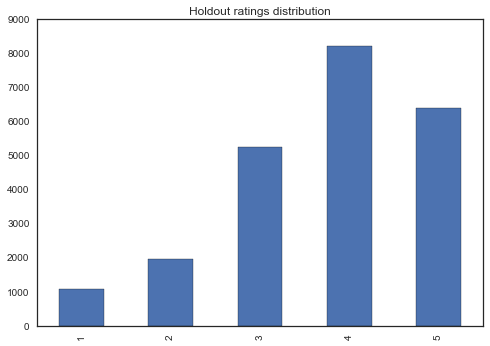

In [30]:
movielens.test.evalset.rating.value_counts().sort_index().plot.bar(title='Holdout ratings distribution')

In [31]:
start_time = timer()
scores_rnd = ee.holdout_test(models, holdout_sizes, metrics)
time_delta = timer() - start_time
time_delta

1 Updating test data.
2 Updating test data.
3 Updating test data.
5 Updating test data.
7 Updating test data.
10 Updating test data.
15 Updating test data.
19 Updating test data.


24.010165980299462

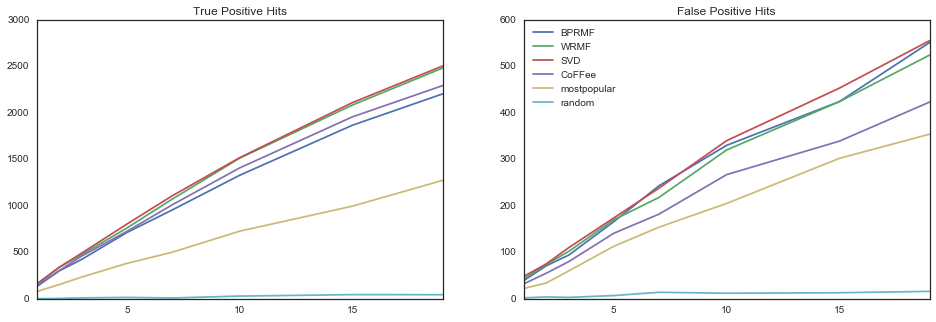

In [32]:
show_hits(scores_rnd)
plt.legend(loc='best')

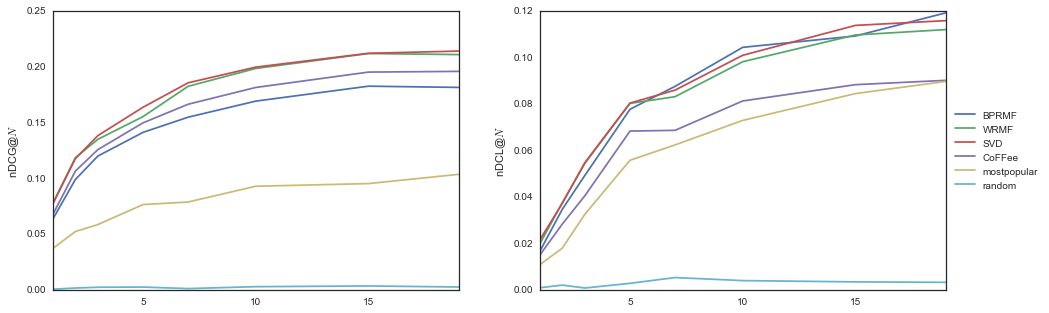

In [33]:
show_ranking(scores_rnd, figsize=(16, 5))

# Dependence on top-k

## Amount of positive and negative ratings per user in the test set

In [34]:
ratings = (movielens.test.testset.rating > 3).groupby(movielens.test.testset.userid).sum().to_frame('positive')
ratings['negative'] = (movielens.test.testset.rating <= 3).groupby(movielens.test.testset.userid).sum()

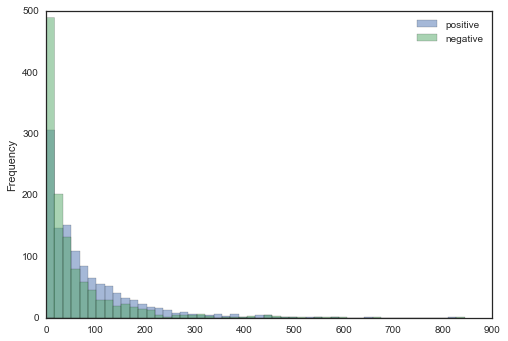

In [35]:
ratings.plot.hist(alpha=0.5, bins=50)

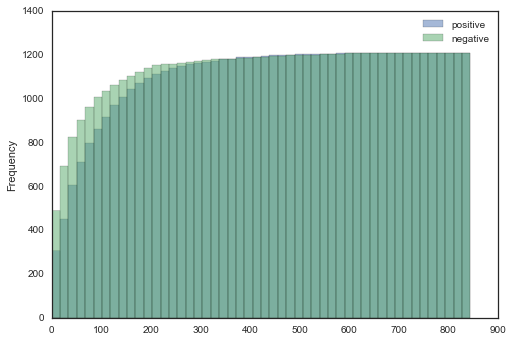

In [36]:
ratings.plot.hist(alpha=0.5, bins=50, cumulative=True)

Shows how likely it is to get high- or low-rated items with random sampling.

## Almost standard scenario (full test data)

In [37]:
# movielens.shuffle_data = True
# movielens.random_seed = 42
movielens.random_holdout = True
movielens.holdout_size = 10
movielens.permute_tops = False
movielens.update()

Updating test data.


In [38]:
movielens.get_configuration()

{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None}

In [39]:
start_time = timer()
topk_scores = ee.topk_test(models, topk_list=topk_list, metrics=metrics)
time_delta = timer() - start_time
time_delta

Test data has been updated. Refreshing the models.
100 70 50 30 20 15 10 5 3 2 1

5.1940104385839305

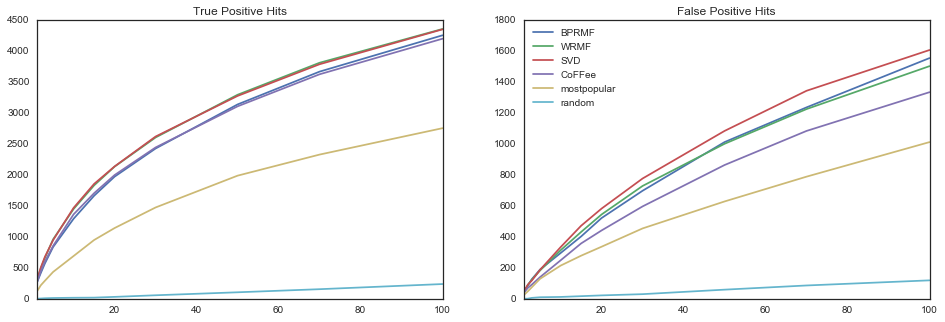

In [40]:
show_hits(topk_scores)
plt.legend(loc='best')

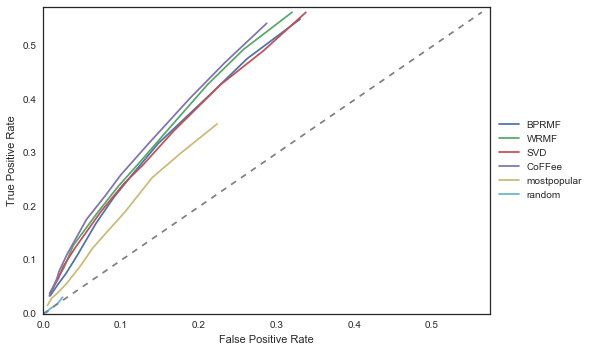

In [41]:
show_hit_rates(topk_scores)

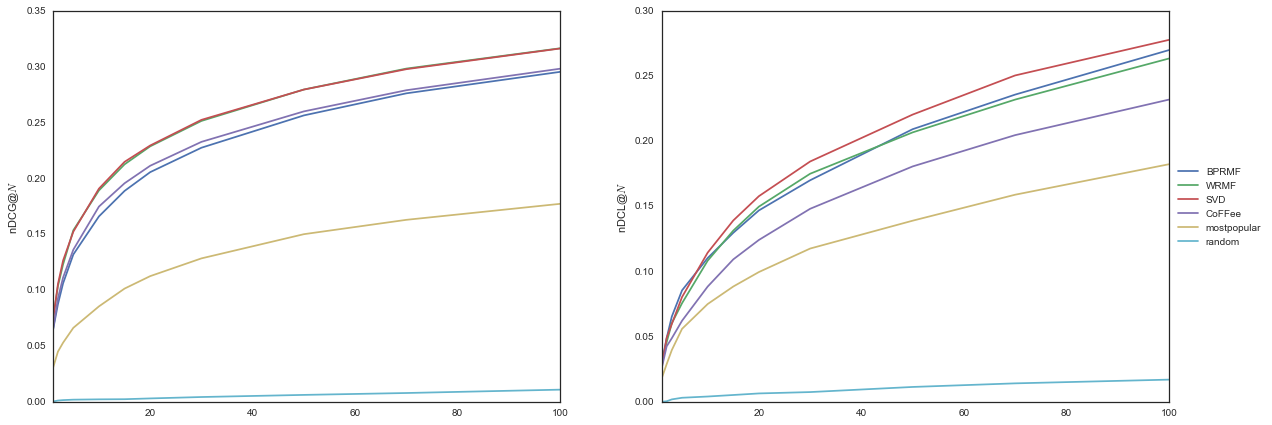

In [42]:
show_ranking(topk_scores, figsize=(20, 7))

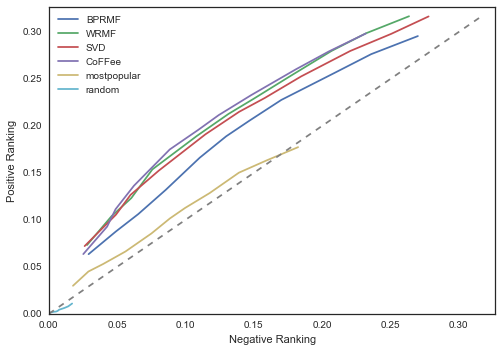

In [43]:
show_ranking_positivity(topk_scores)
plt.legend(loc='best')

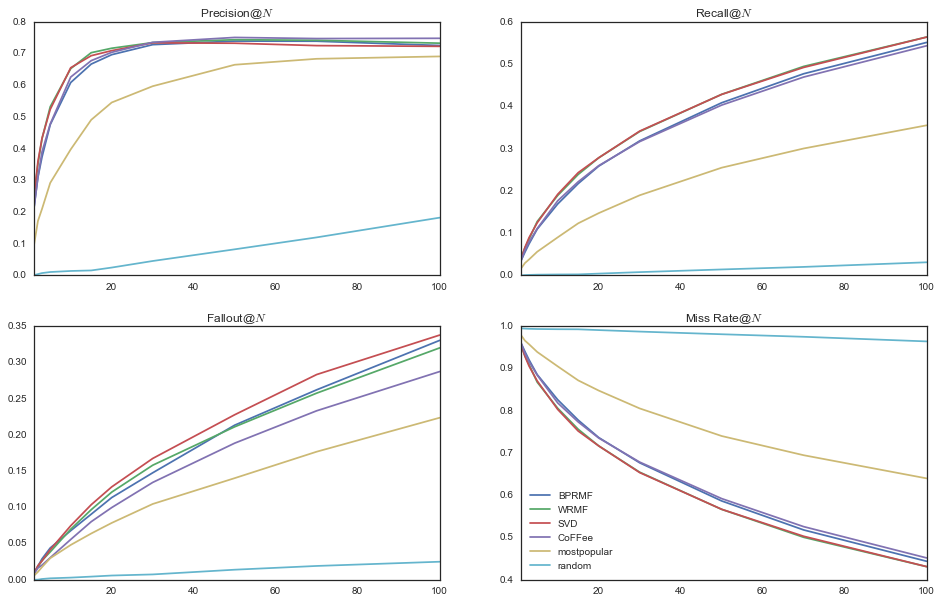

In [44]:
show_relevance(topk_scores)
plt.legend(loc='best')

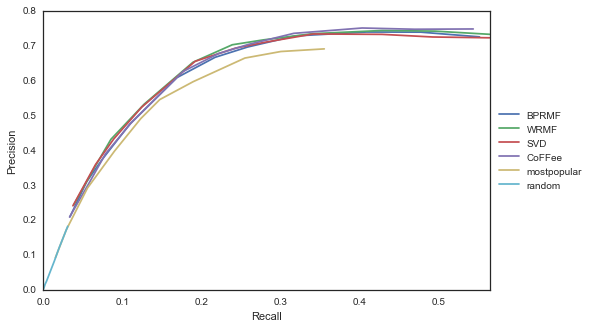

In [45]:
show_precision_recall(topk_scores, figsize=(8, 5))

## Cold-start

### Negative feedback count

In [46]:
movielens.holdout_size = 10
movielens.update()

In [47]:
movielens.get_configuration()

{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None}

In [48]:
neg_groups = (movielens.test.testset.rating < 4).groupby(movielens.test.testset['userid']).sum()

(neg_groups == 0).sum()

4

only 6 users do not have ratings < 4

### From 1 negative

In [49]:
movielens.test_sample = -1
movielens.random_holdout = True
movielens.holdout_size = 10
movielens.update()

Updating test data.


In [50]:
movielens.get_configuration()

{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': -1}

#### Standard models predict highest scores ("direct" predictions scenario)

In [51]:
svd.predict_negative = False
bpr.predict_negative = False
wrmf.predict_negative = False
ee.refresh_models(models)

In [52]:
topk_scores_one_neg = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

Test data has been updated. Refreshing the models.
100 70 50 30 20 15 10 5 3 2 1


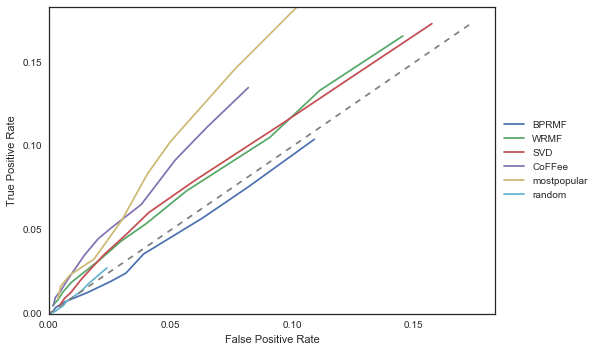

In [53]:
show_hit_rates(topk_scores_one_neg, limit=True)

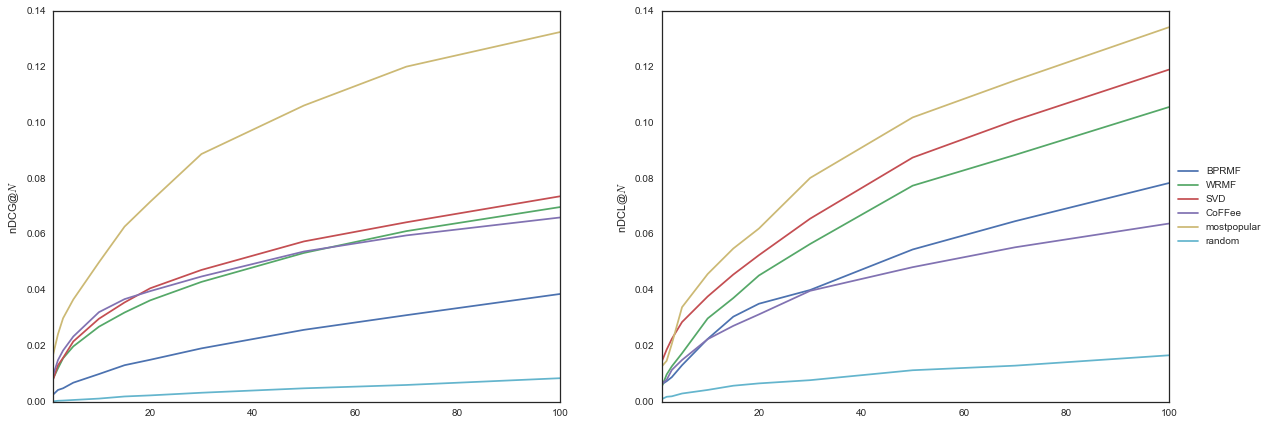

In [54]:
show_ranking(topk_scores_one_neg, figsize=(20, 7))

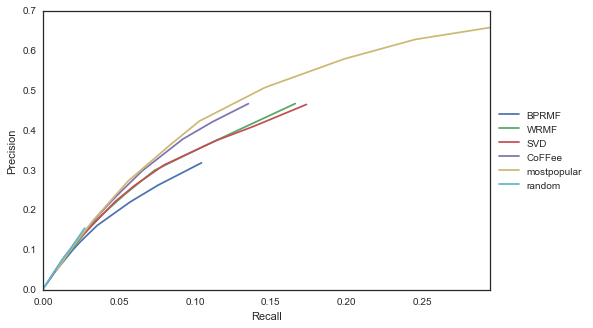

In [55]:
show_precision_recall(topk_scores_one_neg, figsize=(8, 5))

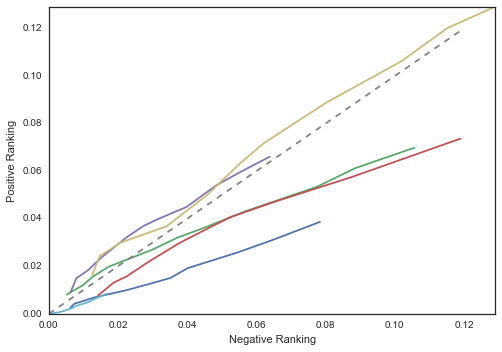

In [56]:
show_ranking_positivity(topk_scores_one_neg)

#### Standard models predict lowest scores ("reversed" prediction)

In [57]:
svd.predict_negative = True
bpr.predict_negative = True
wrmf.predict_negative = True
ee.refresh_models(models)

In [58]:
movielens.update()
movielens.get_configuration()

{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': -1}

In [59]:
topk_scores_one_neg_reversed = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

100 70 50 30 20 15 10 5 3 2 1


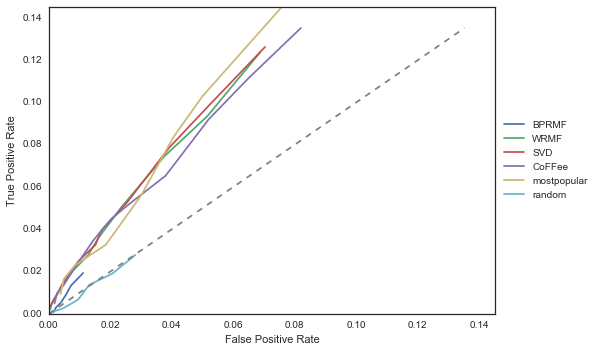

In [60]:
show_hit_rates(topk_scores_one_neg_reversed)

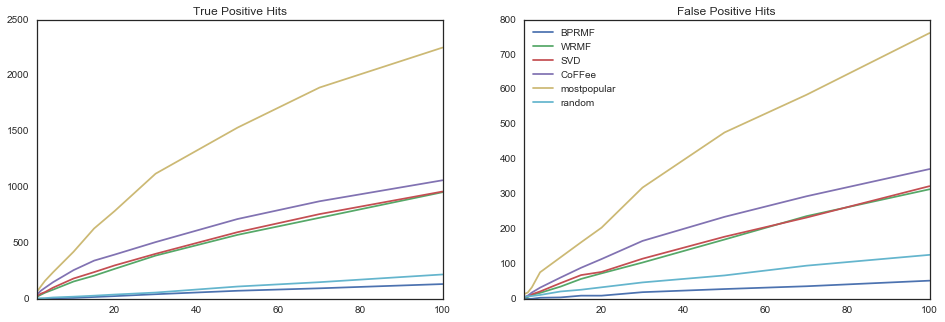

In [61]:
show_hits(topk_scores_one_neg_reversed)
plt.legend(loc='best')

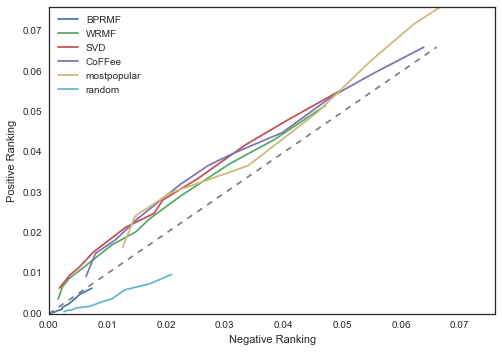

In [62]:
show_ranking_positivity(topk_scores_one_neg_reversed)
plt.legend(loc='best')

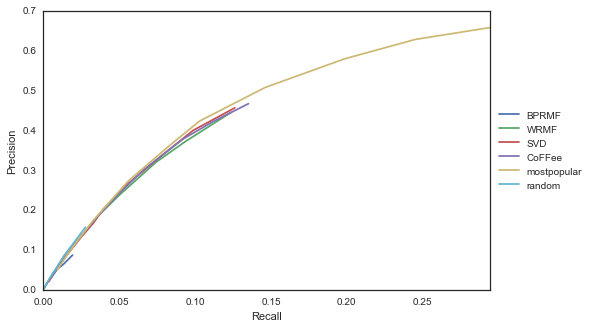

In [63]:
show_precision_recall(topk_scores_one_neg_reversed, figsize=(8, 5))

### From 3 negative

In [64]:
movielens.test_sample = -3
movielens.random_holdout = True
movielens.holdout_size = 10

In [65]:
movielens.update()
movielens.get_configuration()

Updating test data.


{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': -3}

#### Direct

In [66]:
svd.predict_negative = False
bpr.predict_negative = False
wrmf.predict_negative = False
ee.refresh_models(models)

In [67]:
topk_scores_three_neg = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

Test data has been updated. Refreshing the models.
100 70 50 30 20 15 10 5 3 2 1


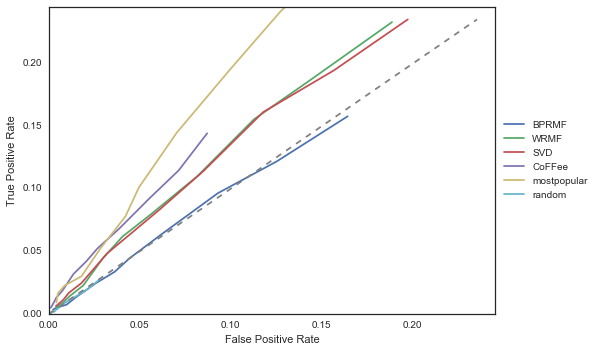

In [68]:
show_hit_rates(topk_scores_three_neg)

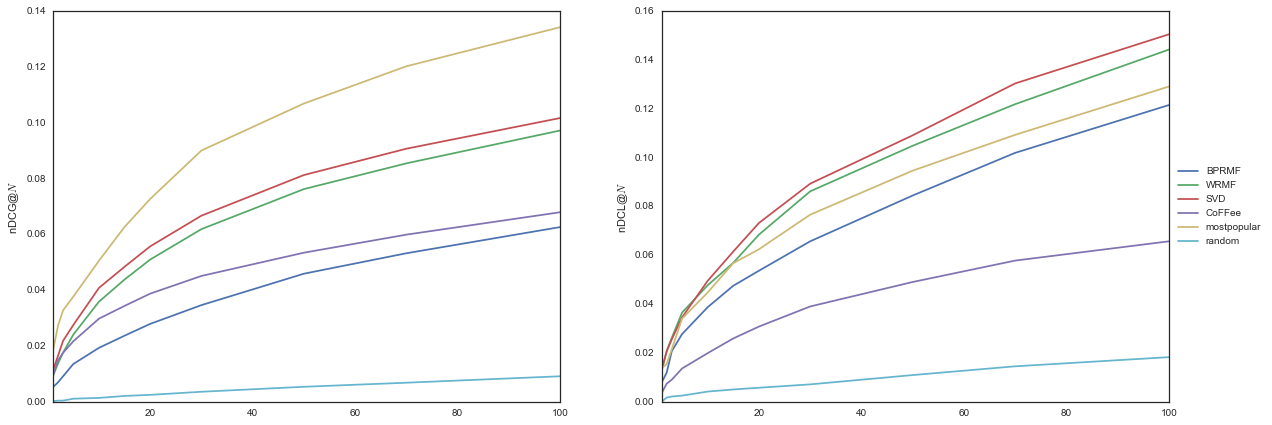

In [69]:
show_ranking(topk_scores_three_neg, figsize=(20, 7))

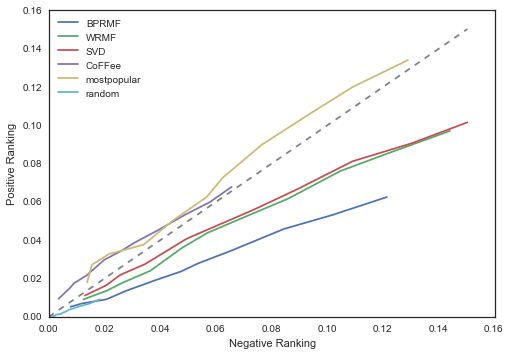

In [70]:
show_ranking_positivity(topk_scores_three_neg)
plt.legend(loc='best')

#### Reversed

In [71]:
svd.predict_negative = True
bpr.predict_negative = True
wrmf.predict_negative = True
ee.refresh_models(models)

In [72]:
movielens.get_configuration()

{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': -3}

In [73]:
topk_scores_three_neg_rev = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

100 70 50 30 20 15 10 5 3 2 1


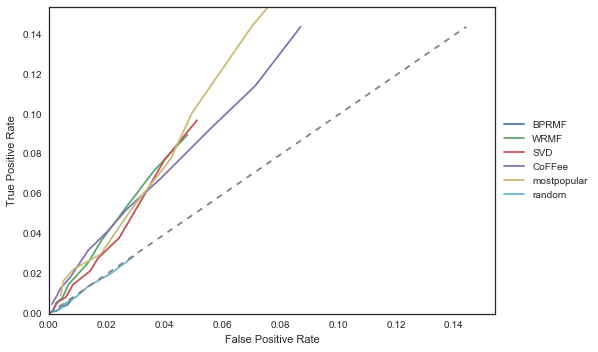

In [74]:
show_hit_rates(topk_scores_three_neg_rev)

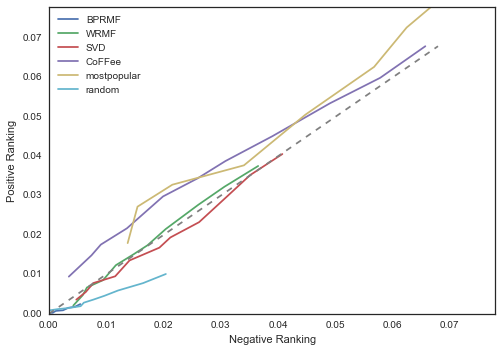

In [75]:
show_ranking_positivity(topk_scores_three_neg_rev, limit=True)
plt.legend(loc='best')

### From 1 random

In [76]:
movielens.test_sample = 1
movielens.random_holdout = True
movielens.holdout_size = 10

In [77]:
movielens.update()
movielens.get_configuration()

Updating test data.


{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': 1}

In [78]:
topk_scores_one_rnd = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

Test data has been updated. Refreshing the models.
100 70 50 30 20 15 10 5 3 2 1


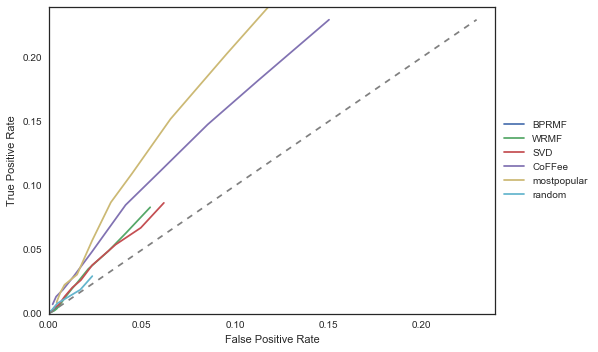

In [79]:
show_hit_rates(topk_scores_one_rnd)

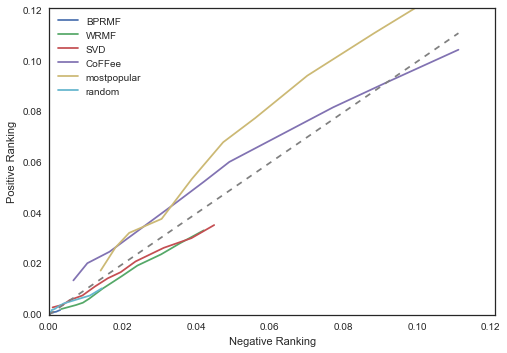

In [80]:
show_ranking_positivity(topk_scores_one_rnd)
plt.legend(loc='best')

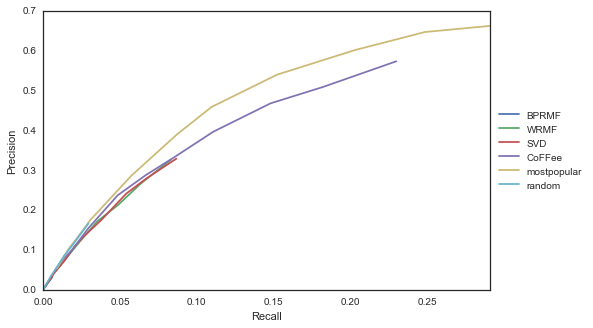

In [81]:
show_precision_recall(topk_scores_one_rnd, figsize=(8, 5))

### From 3 random

In [82]:
movielens.test_sample = 3
movielens.random_holdout = True
movielens.holdout_size = 10

In [83]:
movielens.update()
movielens.get_configuration()

Updating test data.


{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': 3}

In [84]:
topk_scores_three_rnd = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

Test data has been updated. Refreshing the models.
100 70 50 30 20 15 10 5 3 2 1


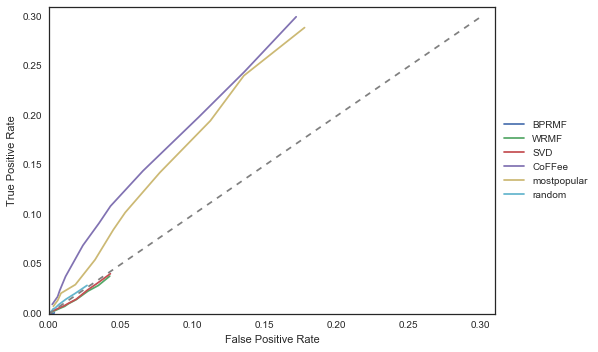

In [85]:
show_hit_rates(topk_scores_three_rnd, limit=True)

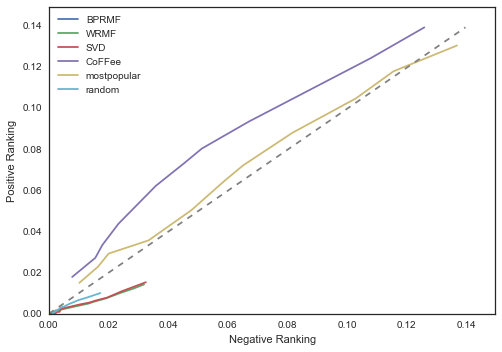

In [86]:
show_ranking_positivity(topk_scores_three_rnd)
plt.legend(loc='best')

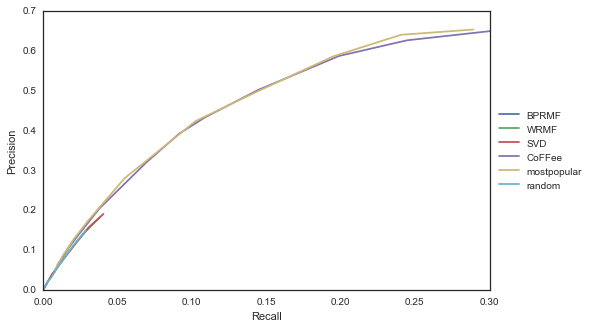

In [87]:
show_precision_recall(topk_scores_three_rnd, figsize=(8, 5))

## From 5 random

In [88]:
movielens.test_sample = 5
movielens.random_holdout = True
movielens.holdout_size = 10

In [89]:
movielens.update()
movielens.get_configuration()

Updating test data.


{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': 5}

In [90]:
topk_scores_five_rnd = ee.topk_test(models, topk_list=topk_list, metrics=metrics)

Test data has been updated. Refreshing the models.
100 70 50 30 20 15 10 5 3 2 1


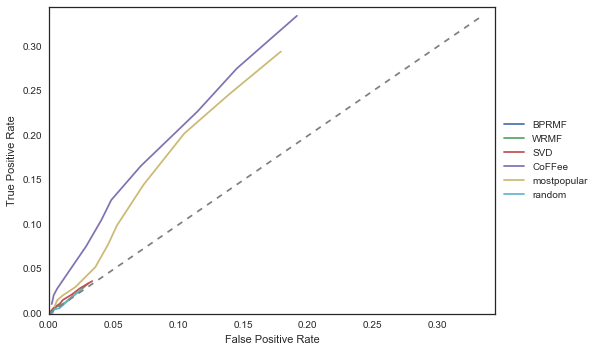

In [91]:
show_hit_rates(topk_scores_five_rnd, limit=True)

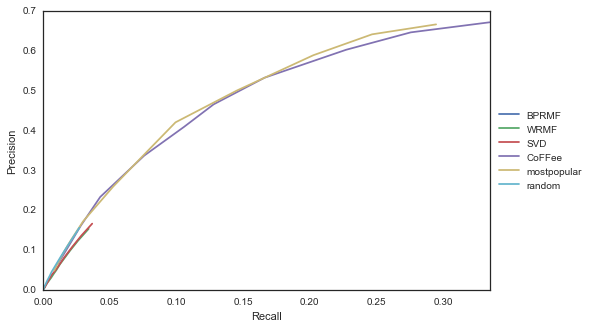

In [92]:
show_precision_recall(topk_scores_five_rnd, figsize=(8, 5))

# Orthogonalization effect on MF methods

In [93]:
bprraw = MyMediaLiteWrapper(lib_path, data_folder, 'BPRrawMF', movielens)
bprraw.name = 'BPRrawMF'
bprraw.orthogonal_factors = False

In [94]:
bprort = MyMediaLiteWrapper(lib_path, data_folder, 'BPRortMF', movielens)
bprort.name = 'BPRortMF' 
bprort.orthogonal_factors = True

In [95]:
movielens.get_configuration()

{'holdout_size': 10,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': True,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': 5}

In [96]:
movielens.prepare()

Preparing data


In [97]:
bprort.build()
bprraw.build()

In [98]:
bprraw.evaluate('hits')

Hits(true_positive=112, true_negative=4205, false_positive=56, false_negative=7707)

In [99]:
bprort.evaluate('hits')

Hits(true_positive=539, true_negative=4137, false_positive=124, false_negative=7280)